In [90]:
%matplotlib widget
import matplotlib.pyplot as plt
from camera import Camera
from dorna2 import Dorna, Kinematic
import numpy as np
import cv2
from ultralytics import YOLO
from IPython.display import display, clear_output

In [98]:
"""
parameters
"""
# robot
tcp_length = 112 # Make sure to put the right toolhead length
robot_ip = "192.168.254.30"# robot ip address
output = [0, [0, 1]] # [output_pin, [off_action, on_action]]

# kinematic
robot_model = "dorna_ta"

# camera
T_cam_2_j4 = np.matrix([[ 5.25873615e-03, -9.99894519e-01,  1.34620306e-02,
          4.65174596e+01],
        [ 9.99959617e-01,  5.35678348e-03, -7.35796480e-03,
          3.20776662e+01],
        [ 7.28773209e-03, -1.35001806e-02,  9.99882310e-01,
         -4.24772615e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])

# detection
trained_model = "test.pt"
detection_conf = 0.5
max_det = 30
area_thr = [500, 12000] # min and max area
xyz_thr = [[190,290], [-260, -160], [3, 90]] # with respect to the robot base

# position
bin_imaging = {"j0":-45,"j1":56,"j2":-128,"j3":0,"j4":-18,"j5":0, "vel":150, "accel":800,"jerk":2000}
object_above = {"vel": 400, "accel": 2000,"jerk":4000}
object_on = {"vel": 400, "accel": 2000,"jerk":4000}

#quality_imaging = {"j0": , "j1": , "j2": , "j3":,  "j4": , "j5": , "vel": 100, "accel": 1000,"jerk": 2000}

drop_above = {"j0":-31.706543,"j1":32,"j2":-63.435059,"j3":3.933105,"j4":-55.986328,"j5":0.021973, "vel": 100, "accel": 1000,"jerk": 2000}
#drop = {"j0": , "j1": , "j2": , "j3":,  "j4": , "j5": , "vel": 100, "accel": 1000,"jerk": 2000}



In [80]:
"""
helper functions
"""
# pick an item with highest confidence that is within the min and max area, retuen the center of the mass of the detected object
def object_location(robot, kinematic, T_cam_2_j4, camera, depth_frame, depth_int, results,  area_thr, xyz_thr):
    sol = False
    xyz_target_2_base = [0, 0, 0]
    pxl = [0, 0]
    
    for result in results:
        for mask in result.masks.xy:
            # conver masks to contour
            cnt = np.int32([mask])
            cnt = cnt.reshape(-1, 2)

            # check area
            area = cv2.contourArea(cnt)
            if area <= min(area_thr) or area >= max(area_thr):
                print("area: ", area)
                continue

            # center in pixel
            M = cv2.moments(cnt)
            # Calculate centroid (center) of the contour
            pxl = [int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])]

            # xyz_target to robot
            xyz_target_2_cam, _ = camera.xyz(pxl, depth_frame, depth_int)
            T_target_2_cam = np.eye(4)
            T_target_2_cam[:3, 3] = np.ravel(xyz_target_2_cam)
            
            # current joint and pose
            joint = robot.get_all_joint()
            T_j4_2_base = kinematic.Ti_r_world(i=5, joint=joint[0:6])
            
            # target_2_base
            T_target_2_base = np.matmul(T_j4_2_base, np.matmul(T_cam_2_j4, T_target_2_cam) )
            xyz_target_2_base =T_target_2_base[:3, 3].flatten().tolist()[0] 

            # check xyz
            if any([xyz_target_2_base[i] <= min(xyz_thr[i]) or xyz_target_2_base[i] >= max(xyz_thr[i]) for i in range(len(xyz_target_2_base))]):
                print("xyz_target_2_base: ", xyz_target_2_base)
                continue
            
            # break the loop
            sol = True
            return xyz_target_2_base, pxl, sol
    
    return xyz_target_2_base, pxl, sol

In [81]:
"""
Initialize model and export it to ncnn formt
"""
# Load a YOLOv8n PyTorch model
model = YOLO(trained_model)

# Export the model to NCNN format
exported_model = model.export(format="ncnn")  # creates 'yolov8n_ncnn_model'

# Load the exported NCNN model
net = YOLO(exported_model, task="segment")

Ultralytics YOLOv8.2.51 🚀 Python-3.11.2 torch-2.3.1 CPU (Cortex-A76)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs

PyTorch: starting from 'test.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (6.5 MB)

TorchScript: starting export with torch 2.3.1...
TorchScript: export success ✅ 8.6s, saved as 'test.torchscript' (12.9 MB)

NCNN: starting export with NCNN 1.0.20240410...
NCNN: running '/usr/local/lib/python3.11/dist-packages/ultralytics/pnnx test.torchscript ncnnparam=test_ncnn_model/model.ncnn.param ncnnbin=test_ncnn_model/model.ncnn.bin ncnnpy=test_ncnn_model/model_ncnn.py pnnxparam=test_ncnn_model/model.pnnx.param pnnxbin=test_ncnn_model/model.pnnx.bin pnnxpy=test_ncnn_model/model_pnnx.py pnnxonnx=test_ncnn_model/model.pnnx.onnx fp16=0 device=cpu inputshape="[1, 3, 640, 640]"'


pnnxparam = test_ncnn_model/model.pnnx.param
pnnxbin = test_ncnn_model/model.pnnx.bin
pnnxpy = test_ncnn_model/model_pnnx.py
pnnxonnx = test_ncnn_model/model.pnnx.onnx
ncnnparam = test_ncnn_model/model.ncnn.param
ncnnbin = test_ncnn_model/model.ncnn.bin
ncnnpy = test_ncnn_model/model_ncnn.py
fp16 = 0
optlevel = 2
device = cpu
inputshape = [1,3,640,640]f32
inputshape2 = 
customop = 
moduleop = 
############# pass_level0
inline module = ultralytics.nn.modules.block.Bottleneck
inline module = ultralytics.nn.modules.block.C2f
inline module = ultralytics.nn.modules.block.DFL
inline module = ultralytics.nn.modules.block.Proto
inline module = ultralytics.nn.modules.block.SPPF
inline module = ultralytics.nn.modules.conv.Concat
inline module = ultralytics.nn.modules.conv.Conv
inline module = ultralytics.nn.modules.head.Segment
inline module = ultralytics.nn.modules.block.Bottleneck
inline module = ultralytics.nn.modules.block.C2f
inline module = ultralytics.nn.modules.block.DFL
inline module = 

NCNN: export success ✅ 3.5s, saved as 'test_ncnn_model' (12.6 MB)

Export complete (14.8s)
Results saved to /home/dorna/Downloads/dorna_vision/example
Predict:         yolo predict task=segment model=test_ncnn_model imgsz=640  
Validate:        yolo val task=segment model=test_ncnn_model imgsz=640 data=/content/Cardamom-1/data.yaml  
Visualize:       https://netron.app


In [6]:
"""
Initialize camera, robot and the inverse kinematic engine
"""

# camera
camera = Camera()
print("Camera connected: ", camera.connect())

# Robot
robot = Dorna()
print("Robot connected: ", robot.connect(robot_ip))

# kinematics
kinematic = Kinematic(robot_model)

Camera connected:  True
Robot connected:  True


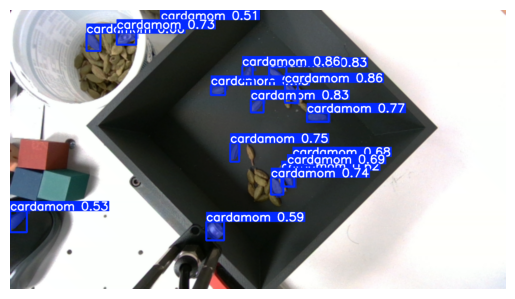

no solution


In [99]:
"""
detection
"""
for i in range(135):
    # bin imaging
    robot.set_motor(1)
    robot.sleep(0.5)
    robot.jmove(rel=0, **bin_imaging)
    robot.sleep(0.5)
    
    # camera data
    depth_frame, _, _, _, _, color_img, depth_int, _, _= camera.get_all()
    
    # detection
    results = net(color_img, half=True, conf=detection_conf, max_det=max_det)
    
    # picking candidate
    xyz_target_2_base, pxl, sol = object_location(robot, kinematic, T_cam_2_j4, camera, depth_frame, depth_int, results, area_thr, xyz_thr)
    print(i, xyz_target_2_base, pxl, sol)

    # Clear the previous output
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)) # Display the image
    plt.axis('off')  # Turn off axis
    display(plt.gcf())  # Display the updated plot
    plt.close() # release the memory

    if sol:
        
        cv2.circle(color_img, pxl, 5, (255, 0, 0), -1)
    else:
        print("no solution")
    """
    # Display the image
    fig, ax = plt.subplots(frameon=False)
    ax.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
    plt.show()
    """
    """
    Command the robot to appraoch the desired pixel from the top.
    Make sure to set the right toolhead parameter
    """
    if sol:
        # above
        robot.lmove(rel=0, x=xyz_target_2_base[0], y=xyz_target_2_base[1], z=xyz_target_2_base[2]+tcp_length+5, **object_above)
        # suction on
        robot.set_output(output[0], output[1][1])
        # attach
        robot.lmove(rel=0, x=xyz_target_2_base[0], y=xyz_target_2_base[1], z=xyz_target_2_base[2]+tcp_length-2, **object_on)
        # sleep
        robot.sleep(0.5)
        # bin_imaging
        robot.jmove(rel=0, **bin_imaging)
        # drop above
        robot.jmove(rel=0, **drop_above)
        # sution off
        robot.set_output(output[0], output[1][0])

In [100]:
"""
Always close the camera and robot, once your application is over
"""
# terminate the session
camera.close()
robot.close()

True